In [40]:
from __future__ import division
import torch
import torch.nn as nn
from torch.jit.annotations import Optional, Tuple
import os
import numpy as np
import os.path
from torchvision import datasets, transforms
import torch.utils.data as datal
import matplotlib.pyplot as plt
import torchvision


### hyper parameters

In [21]:
# hyperparameters
learningRate = 0.00025
numOfEpoch = 30
batchSizeTrain = 32
batchSizeTest = 32
outPutDir = "./data"

# make directory if not exist 
if not os.path.exists(outPutDir):
    os.makedirs(outPutDir)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

###  Data Loading

Files already downloaded and verified
Files already downloaded and verified

Train data shape: (50000, 32, 32, 3)
Test data shape: (10000, 32, 32, 3)
Num classes in train: 10 , in test:  10
Number of instances in train: 50000
Number of instances in test: 10000
Targets:  [0 1 2 3 4 5 6 7 8 9]


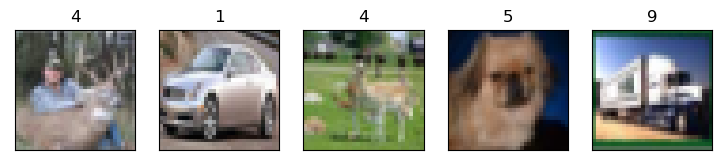

In [44]:
# define an image preprocessing object
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.ToTensor()])
test_transform = transforms.Compose([transforms.ToTensor()])

# download and prepare the data
train_set = datasets.CIFAR10(root=outPutDir, train=True, download=True, transform=train_transform)
train_loader = datal.DataLoader(dataset=train_set, batch_size=batchSizeTrain, shuffle=True)
test_set = datasets.CIFAR10(root=outPutDir, train=False, download=True, transform=test_transform)
test_loader = datal.DataLoader(dataset=test_set, batch_size=batchSizeTest, shuffle=False)

# print the shape of data and number of unique classes in both train and test
print('\nTrain data shape:', train_set.data.shape)
print('Test data shape:', test_set.data.shape)
print('Num classes in train:', len(train_set.classes), ', in test: ', len(train_set.classes))
print('Number of instances in train:', len(train_set))
print('Number of instances in test:', len(test_set))
print('Targets: ',np.unique(train_set.targets))

def showSample():
        # get a batch of images
        dataiter = iter(train_loader)
        images, labels = next(dataiter)

        # plot the first five images
        fig = plt.figure(figsize=(9, 2))
        for idx in range(5):
            ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
            plt.imshow(images[idx].permute(1, 2, 0))
            ax.set_title(str(labels[idx].item()))
showSample()

-----
##  Network

------
### Inception Module with dimension reductions (There exist many implement methods)

In [28]:
class Inception(nn.Module):
    def __init__(self, in_planes, kernel_1_x, kernel_3_in, kernel_3_x, kernel_5_in, kernel_5_x, pool_planes):
        super(Inception, self).__init__()
        # 1x1 conv branch
        # b1 is a block consists of 2D convolution, a 2D batch normalization layer and a ReLU activation function
        self.b1 = nn.Sequential(
            nn.Conv2d(in_planes, kernel_1_x, kernel_size=1),
            nn.BatchNorm2d(kernel_1_x),
            nn.ReLU(True),
        )

        # 1x1 conv -> 3x3 conv branch
        # b2 is a block consists of two 2D convolutions, two 2D batch normalization layers and tow ReLU activation functions
        self.b2 = nn.Sequential(
            nn.Conv2d(in_planes,kernel_3_in,kernel_size=1),
            nn.BatchNorm2d(kernel_3_in),
            nn.ReLU(inplace=True),
            nn.Conv2d(kernel_3_in,kernel_3_x,kernel_size=3,padding=1),
            nn.BatchNorm2d(kernel_3_x),
            nn.ReLU(inplace=True),
        )

        # 1x1 conv -> 5x5 conv branch
        # b3 is a block consists of two 2D convolutions, two 2D batch normalization layers and two ReLU activation functions
        self.b3 = nn.Sequential(
            nn.Conv2d(in_planes,kernel_5_in,kernel_size=1),
            nn.BatchNorm2d(kernel_5_in),
            nn.ReLU(inplace=True),
            nn.Conv2d(kernel_5_in,kernel_5_x,kernel_size=5,padding=2),
            nn.BatchNorm2d(kernel_5_x),
            nn.ReLU(inplace=True),
        )
         
        # 3x3 pool -> 1x1 conv branch
        # b4 is a block consists of a Maxpooling layer, a 2D convolution, a 2D batch normalization layer and a ReLU activation function
        self.b4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3,stride=1,padding=1),
            nn.Conv2d(in_planes,pool_planes,kernel_size=1),
            nn.BatchNorm2d(pool_planes),
            nn.ReLU(inplace=True),
        )
    # This forward function will forward the input function though every block and return the concatenation of all the output.
    def forward(self,x):
        y1=self.b1(x) 
        y2=self.b2(x) 
        y3=self.b3(x) 
        y4=self.b4(x) 
        return torch.cat([y1,y2,y3,y4],dim=1)


-----
### GoogLeNet Module (There exist many implement methods)

In [29]:
# python class called GoogLeNet which inherits nn.module
class GoogLeNet(nn.Module):
    def __init__(self):
        super(GoogLeNet, self).__init__()
        
        # serves as all layers before the inception, which contains a 2D convolution with padding=1, kernel_size=3 output channel=192, a 2D batch normalization layer and a ReLU activation fucntion.
        self.bg = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=192, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features = 192),
            nn.ReLU(True),
        )
        
        # Inception blocks
        self.inception1 = Inception(192, 64, 96, 128, 16, 32, 32)
        self.inception2 = Inception(256, 128, 128, 192, 32, 96, 64)
        
        # Maxpooling layer
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode = True, padding=1)
        
        # Five Inception blocks
        self.inception3 = Inception(480, 192, 96, 208, 16, 48, 64)
        self.inception4 = Inception(512, 160, 112, 224, 24, 64, 64)
        self.inception5 = Inception(512, 128, 128, 256, 24, 64, 64)
        self.inception6 = Inception(512, 112, 144, 288, 32, 64, 64)
        self.inception7 = Inception(528, 256, 160, 320, 32, 128, 128)
        
        # Maxpooling layer
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode = True, padding=1)
        
        # Two Inception blocks
        self.inception8 = Inception(832, 256, 160, 320, 32, 128, 128)
        self.inception9 = Inception(832, 384, 192, 384, 48, 128, 128)
        
        # Average Pooling layer
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        
        # Fully connected layer
        self.fc = nn.Linear(in_features=1024, out_features=10)
        
    # this forward function will forward the input function though every block and return the output
    def forward(self, x):
        x = self.bg(x)
        x = self.inception1(x)
        x = self.inception2(x)
        
        x = self.maxpool1(x)
        
        x = self.inception3(x)
        x = self.inception4(x)
        x = self.inception5(x)
        x = self.inception6(x)
        x = self.inception7(x)
        
        x = self.maxpool2(x)
        
        x = self.inception8(x)
        x = self.inception9(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x,1)
        
        x = self.fc(x)
        
        return x

### Next, we create the network and send it to the target device

In [30]:
# Next, we create the network and send it to the target device
model = GoogLeNet().to(device)

# an optimizer, criterion, scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=learningRate, weight_decay=learningRate)
criterion = nn.CrossEntropyLoss()
# criterion = nn.NLLLoss() # Negative Log Likelihood Loss but does not work well
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True)

# list to store the values
train_losses =[]
test_losses = []
train_accs = []
test_accs = []

# for each epoch
for epoch in range(numOfEpoch):

    # 1: train the model
    model.train()
    train_loss = 0
    total = 0
    correct = 0

    # loop over training data in batches
    for data, labels in train_loader:
        data, labels = data.to(device), labels.to(device)

        # reset the parameter gradients
        optimizer.zero_grad()
        outputs = model.forward(data)       # forward pass
        loss = criterion(outputs, labels)   # calculate loss

        loss.backward()                 # backward pass
        optimizer.step()                # update parameters using calculated gradients
        train_loss += loss.item()       
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)

        # number of correctly classified training examples in this epoch
        correct += (predicted == labels).sum().item()   

    train_loss /= len(train_loader) 
    train_losses.append(train_loss)
    train_acc =correct/total
    train_accs.append(train_acc)


    # 2: test the model
    model.eval()
    test_loss = 0
    total = 0
    correct = 0

    # disable gradient calculation
    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model.forward(data)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)

            # number of correctly classified testing examples in this epoch
            correct += (predicted == labels).sum().item()

    test_loss /= len(test_loader) 
    test_losses.append(test_loss)
    test_acc = correct/total
    test_accs.append(test_acc)

    # print
    print('Epoch [{}/{}], Loss: train:{:.4f}, test:{:.4f} | Accuracy: train: {:.2f}%, test:{:.2f}%'.format(epoch+1, numOfEpoch, train_loss, test_loss , 100*train_acc, 100*test_acc))
    # update learning rate based on validation loss for this epoch
    scheduler.step(test_loss)


Epoch [1/30], Loss: train:1.1001, test:1.1141 | Accuracy: train: 60.66%, test:61.42%
Epoch [2/30], Loss: train:0.6584, test:0.6430 | Accuracy: train: 77.30%, test:77.89%
Epoch [3/30], Loss: train:0.5154, test:0.5051 | Accuracy: train: 82.34%, test:82.81%
Epoch [4/30], Loss: train:0.4317, test:0.4849 | Accuracy: train: 85.25%, test:83.56%
Epoch [5/30], Loss: train:0.3763, test:0.4311 | Accuracy: train: 87.07%, test:84.94%
Epoch [6/30], Loss: train:0.3286, test:0.4174 | Accuracy: train: 88.77%, test:85.53%
Epoch [7/30], Loss: train:0.2971, test:0.4434 | Accuracy: train: 89.97%, test:84.97%
Epoch [8/30], Loss: train:0.2719, test:0.4006 | Accuracy: train: 90.69%, test:86.41%
Epoch [9/30], Loss: train:0.2449, test:0.3915 | Accuracy: train: 91.61%, test:86.98%
Epoch [10/30], Loss: train:0.2260, test:0.3434 | Accuracy: train: 92.19%, test:88.75%
Epoch [11/30], Loss: train:0.2070, test:0.3281 | Accuracy: train: 92.91%, test:89.04%
Epoch [12/30], Loss: train:0.1907, test:0.3905 | Accuracy: trai

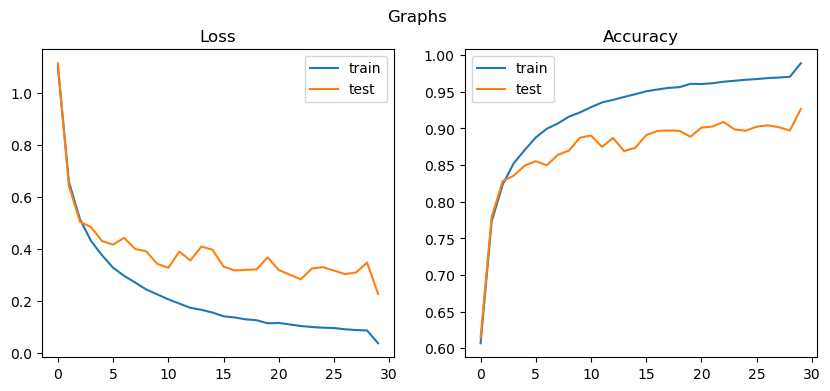

In [45]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
fig.suptitle('Graphs')

ax1.plot(train_losses, label='train')
ax1.plot(test_losses, label='test')
ax1.set_title('Loss')
ax1.legend()

ax2.plot(train_accs, label='train')
ax2.plot(test_accs, label='test')
ax2.set_title('Accuracy')
ax2.legend()

plt.show()